# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**


**NOTE to run code locally:** add data (data_d3.pickle, data_d4.pickle) to **assignment-3/data/** folder

## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [83]:
# !pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.3 MB/s eta 0:00:00a 0:00:01


In [89]:
### Your code Here
import pickle
from itertools import islice

data_d3=pickle.load(open("data/data_d3.pickle", "rb"))
data_d4=pickle.load(open("data/data_d4.pickle", "rb"))

first_elements = list(islice(data_d3, 5))
print(first_elements[0])
print(data_d3[first_elements[0]])
print(len(data_d3[first_elements[0]]))
print(len(data_d3[first_elements[1]])) # => elements in dict have different amount of elements in them

A0A024R1R8
{1, 771, 775, 263, 137, 11, 531, 1176, 922, 30, 927, 1185, 673, 675, 423, 296, 1704, 2043, 813, 304, 48, 52, 693, 1080, 1083, 1211, 1085, 1469, 69, 454, 1865, 458, 842, 1609, 1618, 467, 1109, 214, 1237, 473, 90, 603, 1379, 229, 1768, 1513, 1260, 109, 1645, 1007, 112, 1521, 242, 2035, 1652, 1525, 1270, 119, 1017, 123, 508, 1149}
62
178


## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [90]:
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
from IPython.display import display
import itertools

### Add supporting functions here
def create_sparse_matrix(data):
    uniprot_ids = list(data.keys())
    structural_features = list(data.values())

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(len(uniprot_ids), num_features))
    
    return sparse_matrix, uniprot_ids

def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T  # Transpose the matrix
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]  # Adjust indexing for dense matrix
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

def compare_characteristics(df, proteins):
    subset = df.loc[proteins]
    num_columns_differ = (subset.iloc[0] != subset.iloc[1]).sum()
    total_columns = len(subset.columns)
    num_columns_match = total_columns - num_columns_differ

    # Calculate the number of shared 1s between the proteins
    shared_1s = ((subset.iloc[0] == 1) & (subset.iloc[1] == 1)).sum()

    # Calculate the total number of 1s if both proteins had the same characteristics
    total_1s = subset.iloc[0].sum() + subset.iloc[1].sum() - shared_1s

    return num_columns_differ, num_columns_match, shared_1s, total_1s

def get_probabilities(s_values, band_values, row_values):
    # Get probabilities
    probabilities = []
    for b_val in band_values:
        for r_val in row_values:
            for s in s_values:
                probability = 1 - (1 - s ** r_val) ** b_val
                probabilities.append([probability, b_val, r_val, s])
                # print("The probability that proteins share at least one band signature if they are %4.2f similar is: %7.4f" % (s, probability))
    return probabilities

def jaccard_similarity(protein1, protein2):
    intersection = np.sum(np.minimum(protein1, protein2))
    union = np.sum(np.maximum(protein1, protein2))
    return intersection / union

def extract_similar_pairs(buckets, uniprot_ids, df):
    similar_pairs = []
    for (b, buck), docs in buckets.items():
        if len(docs) > 1:
            #print("Band", b, "suggests these similar docs:", [uniprot_ids[d] for d in docs])
            combs = itertools.combinations(docs, 2)
            for i, j in combs:
                protein1 = df.iloc[i].values
                protein2 = df.iloc[j].values
                jaccard_sim = jaccard_similarity(protein1, protein2)
                

                num_differ, num_match, shared_1s, total_1s = compare_characteristics(df, [uniprot_ids[i], uniprot_ids[j]])
                similar_pairs.append((uniprot_ids[i], uniprot_ids[j], num_differ, num_match, shared_1s, total_1s, jaccard_sim))
                
                if len(similar_pairs) >= 20:  # Limit to 20 pairs
                    return similar_pairs
    return similar_pairs

In [91]:
# Test different values of B and R
bands_values = [10 ,20, 40, 60, 80, 120]  # Adjust the values as needed
rows_values = [2, 4, 8, 10, 16]  # Adjust the values as needed

s_values = [0.5, 0.85]
probs = get_probabilities(s_values, bands_values, rows_values)

probs_df = pd.DataFrame(probs, columns=["Probability", "Num_band", "Num_row", "similarity"])

# Only filter out values that pass our requirements
promissing_params = probs_df[(((probs_df["Probability"] < 0.3) & (probs_df["similarity"] == 0.5)) & ((probs_df["Probability"] > 0.1) & (probs_df["similarity"] == 0.5))) | ((probs_df["Probability"] > 0.85) & (probs_df["similarity"] == 0.85))]

print("Final promising parameters")
final_promising = promissing_params[promissing_params.duplicated(subset=["Num_band", "Num_row"])]

bands_values = [40, 60, 80]
rows_values = [8]

s_values = [0.5, 0.6, 0.7, 0.85, 0.9, 0.95]
probs = get_probabilities(s_values, bands_values, rows_values)
final_probs_df = pd.DataFrame(probs, columns=["Probability", "Num_band", "Num_row", "similarity"])
display(final_probs_df)

# => we will use b = 80 and r = 8 (see our analysis text for detailed explanation)
print("\n\n\n\n")

# Create sparse matrices for both datasets
sparse_matrix_d3, uniprot_ids_d3 = create_sparse_matrix(data_d3)
sparse_matrix_d4, uniprot_ids_d4 = create_sparse_matrix(data_d4)

# Create dense matrices for both datasets
dense_matrix_d3 = sparse_matrix_d3.toarray()
dense_matrix_d4 = sparse_matrix_d4.toarray()

df_d3 = pd.DataFrame(dense_matrix_d3, index=uniprot_ids_d3)
df_d4 = pd.DataFrame(dense_matrix_d4, index=uniprot_ids_d4)

# Use LSHT to find similar proteins
buckets_d3 = LSHT(dense_matrix_d3, 80, 8)
buckets_d4 = LSHT(dense_matrix_d4, 80, 8)

# Extract similar pairs and include Jaccard similarity
similar_pairs_d3 = extract_similar_pairs(buckets_d3, uniprot_ids_d3, df_d3)
similar_pairs_d4 = extract_similar_pairs(buckets_d4, uniprot_ids_d4, df_d4)

# Create DataFrames with Jaccard similarity included
df_similar_pairs_d3 = pd.DataFrame(similar_pairs_d3, columns=['Protein 1', 'Protein 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics', 'Jaccard Similarity'])
df_similar_pairs_d4 = pd.DataFrame(similar_pairs_d4, columns=['Protein 1', 'Protein 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics', 'Jaccard Similarity'])

display("Sparse matrix shape for data_d3:", sparse_matrix_d3.shape)
display("Sparse matrix shape for data_d4:", sparse_matrix_d4.shape)


# Display similar protein pairs for data_d3
display("Similar protein pairs for data_d3:")
count_d3 = 0
for (b, buck), docs in buckets_d3.items():
    if len(docs) > 1 and count_d3 < 20:
        similar_proteins = [uniprot_ids_d3[d] for d in docs]
        display(f"Band {b} suggests these similar proteins: {similar_proteins}")
        count_d3 += 1

# Display similar protein pairs for data_d4
display("Similar protein pairs for data_d4:")
count_d4 = 0
for (b, buck), docs in buckets_d4.items():
    if len(docs) > 1 and count_d4 < 20:
        similar_proteins = [uniprot_ids_d4[d] for d in docs]
        display(f"Band {b} suggests these similar proteins: {similar_proteins}")
        count_d4 += 1
        
        
# Print similar protein pairs for data_d3
print("Similar protein pairs for data_d3:")
display(df_similar_pairs_d3)

# Print similar protein pairs for data_d4
print("Similar protein pairs for data_d4:")
display(df_similar_pairs_d4)

Final promising parameters


,Probability,Num_band,Num_row,similarity
0,0.144916,40,8,0.50
1,0.492142,40,8,0.60
2,0.906991,40,8,0.70
3,0.999997,40,8,0.85
4,1.000000,40,8,0.90
5,1.000000,40,8,0.95
6,0.209298,60,8,0.50
7,0.638079,60,8,0.60
8,0.971635,60,8,0.70
9,1.000000,60,8,0.85


'Sparse matrix shape for data_d3:'

(19258, 2048)

'Sparse matrix shape for data_d4:'

(19258, 20736)

'Similar protein pairs for data_d3:'

"Band 0 suggests these similar proteins: ['A0A024RBG1', 'Q9NZJ9']"

"Band 0 suggests these similar proteins: ['A0A075B6P5', 'P01615']"

"Band 0 suggests these similar proteins: ['A0A075B6S2', 'A0A0C4DH68']"

"Band 0 suggests these similar proteins: ['A0A075B6S6', 'P06310']"

"Band 0 suggests these similar proteins: ['Q6IPX1', 'A0A087WVF3']"

"Band 0 suggests these similar proteins: ['A0A087WW87', 'P01614']"

"Band 0 suggests these similar proteins: ['A6NER0', 'A0A087X179']"

"Band 0 suggests these similar proteins: ['P07919', 'A0A096LP55']"

"Band 0 suggests these similar proteins: ['A0A0A0MT36', 'A0A0C4DH24']"

"Band 0 suggests these similar proteins: ['A0JP26', 'A0A0A6YYL3']"

"Band 0 suggests these similar proteins: ['A0A0B4J2D9', 'P0DP09']"

"Band 0 suggests these similar proteins: ['A0A0B4J2F2', 'P57059']"

"Band 0 suggests these similar proteins: ['P01742', 'A0A0B4J2H0']"

"Band 0 suggests these similar proteins: ['P01619', 'A0A0C4DH25']"

"Band 0 suggests these similar proteins: ['P01825', 'P0DP06', 'A0A0C4DH41']"

"Band 0 suggests these similar proteins: ['P01767', 'A0A0C4DH42']"

"Band 0 suggests these similar proteins: ['P01597', 'A0A0C4DH67', 'P04432']"

"Band 0 suggests these similar proteins: ['P01611', 'A0A0C4DH73']"

"Band 0 suggests these similar proteins: ['P0DPF7', 'A0A0J9YXY3']"

"Band 0 suggests these similar proteins: ['A0A1B0GTK5', 'P0DP71']"

'Similar protein pairs for data_d4:'

"Band 0 suggests these similar proteins: ['P34932', 'Q16401']"

"Band 0 suggests these similar proteins: ['P0CL82', 'P0DSO3', 'O76087', 'P0CL80', 'P0DTW1', 'P0CL81', 'Q13069']"

"Band 0 suggests these similar proteins: ['P47813', 'O14602']"

"Band 0 suggests these similar proteins: ['Q9QC07', 'Q9BXR3', 'Q9UQG0', 'P10266']"

"Band 0 suggests these similar proteins: ['P0CI25', 'P0CI26']"

"Band 0 suggests these similar proteins: ['Q16777', 'Q9BTM1', 'Q99878', 'P0C0S8', 'Q8IUE6']"

"Band 0 suggests these similar proteins: ['Q6ZUB0', 'P0C874']"

"Band 0 suggests these similar proteins: ['P63120', 'P63129']"

"Band 0 suggests these similar proteins: ['P0C0S5', 'Q71UI9']"

"Band 0 suggests these similar proteins: ['Q6RFH8', 'P0CJ90', 'Q9UBX2']"

"Band 0 suggests these similar proteins: ['P19961', 'P0DTE8']"

"Band 0 suggests these similar proteins: ['P01593', 'P01594']"

"Band 0 suggests these similar proteins: ['P01850', 'A0A5B9']"

"Band 0 suggests these similar proteins: ['P01614', 'A0A087WW87']"

"Band 0 suggests these similar proteins: ['Q99877', 'P62807', 'Q93079', 'P58876', 'O60814', 'Q5QNW6']"

"Band 0 suggests these similar proteins: ['P0C7W8', 'P0C7V4']"

"Band 0 suggests these similar proteins: ['P0DPH9', 'A0A1B0GTR3']"

"Band 0 suggests these similar proteins: ['O00571', 'O15523']"

"Band 0 suggests these similar proteins: ['Q9UQ88', 'P21127']"

"Band 0 suggests these similar proteins: ['Q96AQ1', 'Q96LY2']"

Similar protein pairs for data_d3:


,Protein 1,Protein 2,Characteristics Differ,Total Match,Shared Characteristics,Total Characteristics,Jaccard Similarity
0,A0A024RBG1,Q9NZJ9,13,2035,175,188,0.930851
1,A0A075B6P5,P01615,2,2046,123,125,0.984000
2,A0A075B6S2,A0A0C4DH68,58,1990,95,153,0.620915
3,A0A075B6S6,P06310,9,2039,130,139,0.935252
4,Q6IPX1,A0A087WVF3,29,2019,361,390,0.925641
5,A0A087WW87,P01614,1,2047,127,128,0.992188
6,A6NER0,A0A087X179,50,1998,347,397,0.874055
7,P07919,A0A096LP55,20,2028,90,110,0.818182
8,A0A0A0MT36,A0A0C4DH24,19,2029,110,129,0.852713
9,A0JP26,A0A0A6YYL3,51,1997,305,356,0.856742


Similar protein pairs for data_d4:


,Protein 1,Protein 2,Characteristics Differ,Total Match,Shared Characteristics,Total Characteristics,Jaccard Similarity
0,P34932,Q16401,2530,18206,696,3226,0.215747
1,P0CL82,P0DSO3,23,20713,171,194,0.881443
2,P0CL82,O76087,9,20727,178,187,0.951872
3,P0CL82,P0CL80,8,20728,178,186,0.956989
4,P0CL82,P0DTW1,35,20701,162,197,0.822335
5,P0CL82,P0CL81,7,20729,178,185,0.962162
6,P0CL82,Q13069,33,20703,165,198,0.833333
7,P0DSO3,O76087,14,20722,177,191,0.926702
8,P0DSO3,P0CL80,17,20719,175,192,0.911458
9,P0DSO3,P0DTW1,18,20718,172,190,0.905263


### Your short analysis here

#### **Dataset Overview**
We are working with two datasets that correspond to approximately 99% of the Human Proteins. Each dataset is presented in a dictionary format where the key is the UniProtID of a protein and the value is a set of indices representing specific structural characteristics. 

The datasets are:

data_d3.pickle - A smaller set of structural features with 2048 features.

data_d4.pickle - A larger set of structural features with 20736 features.

### **Local Sensitivity Hashing (LSH)**

LSH is performed on both datasets to find similar proteins. The parameters B (number of bands) and R (number of rows per band) are varied to observe the effect on capturing similar protein pairs.



For data_d3, the following are some of the similar protein pairs identified using LSH:


* Band 0 suggests these similar proteins: ['A0A024RBG1', 'Q9NZJ9']
* Band 0 suggests these similar proteins: ['A0A075B6P5', 'P01615']


For data_d4, the following are some of the similar protein pairs identified using LSH:

* Band 0 suggests these similar proteins: ['P34932', 'Q16401']
* Band 0 suggests these similar proteins: ['P0CL82', 'P0DSO3', 'O76087', 'P0CL80', 'P0DTW1', 'P0CL81', 'Q13069']



### **Detailed Analysis of Similar Protein Pairs**

We analyzed the characteristics of the similar protein pairs identified. Here are some of the detailed results for data_d3:



#### For data_d3:

* A0A024RBG1 (NUD4B_HUMAN) and Q9NZJ9 (NUDT4_HUMAN) share 177 specific structural characteristics and differ in 13 characteristics, with a total of 188 characteristics that they could share if they were exactly the same protein based on this structural characteristics.
* A0A075B6P5 (KV228_HUMAN) and P01615 (KVD28_HUMAN) share 123 specific structural characteristics and differ in 2 characteristics, with a total of 125 characteristics that they could share if they were exactly the same protein based on this structural characteristics.


A quick look at the Uniprot website reveals that both pairs belong to the same protein family, suggesting that the matching found using the LSH also has biological relevance.


#### For data_d4:


* P34932 (HSP74_HUMAN) and Q16401 (PSMD5_HUMAN) share 696 specific structural characteristics and differ in 2530	 characteristics, with a total of 3226 characteristics that they could share if they were exactly the same protein based on this structural characteristics.
* P0CL82 (GG12I_HUMAN) and  P0DSO3 (GAGE4_HUMAN) share 171 specific structural characteristics and differ in  23	 characteristics, with a total of 194 characteristics that they could share if they were exactly the same protein based on this structural characteristics.


A quick look at the Uniprot website reveals that the frist pair of proteins P34932 (HSP74_HUMAN) and Q16401 (PSMD5_HUMAN) do no share the same protein family or any biological function.
For the second group of proteins P0CL82, P0DSO3, O76087, P0CL80, P0DTW1, P0CL81, Q13069 all of them belong to the GAGE family suggesting a biological similarity between them.
 

### Finding the best values for bands and rows

In order to find the best values for the hyperparameters bands and rows, we used the following formular: 

<br>p = 1 - (1 - similarity ** rows) ** bands<br>

This formula represents the probability that two documents will share at least one band signature if their similarity is s. It helps to reflect the effectiveness of the LSH parameters b and r in distinguishing similar from dissimilar documents. We are using this method with different combinations of bands and rows and evaluate their results. To decide which values for the parameter we restrict the possible parameters so for a s = 0.5 the probability is smaller 0.3 but higher 0.1 and for s = 0.85 the probability larger 0.85. Our goal is to group the most similar documents but still also documents that are already 0.5 similar to each other should be captured to some extend. We decide for the values b = 80 and r = 8 as this captures the most similar documents but also takes into account documents, in our case proteins, that are only to 60% similar. Other configurations like b = 10 and r = 10 would only capture proteins that are 50% similar to a probabilty of 0.09%, so this is not an option as many combinations will get "lost" even though they are similar to some extend.


### Challenges along the way:

The biggest challenge to us was how to evaluate the resulting entries/ buckets of the LSH in terms of false positives, so we could really evaluate how good the grouping of LSH is. Using the formular **1 - (1 - similarity ** rows) ** bands** that we applied in the, it totally doesn't take into account our data, which therefore was somewhat confusing to us. Therefore in the beginning we run many different configurations for rows and bands and measured there time to at least compare them to some extend. But in order to evaluating the real performance we would need to calculate the Jacard Similarity for every combination, which would be way too computation intensive. In addition we also would need to figure out the false positives, so proteins that got inserted into a single entry of a bucket even though they have high similarity with some other proteins. In the end we decided to just calculate the Jaccard Similarity for the first 20 combinations that are in the same entry of the bucket and evaluate the resulting scores by hand.


### **Conclusion**

Local Sensitivity Hashing (LSH) effectively captures similar protein pairs in large proteomic datasets. By adjusting the parameters B and R, we can control the granularity of similarity detection and the computational cost. Identifying similar proteins can lead to insights into shared properties and functional relationships, which can be further verified through databases like UniProt.

In this specific scenario, when applying LSH to both datasets, it appears that the pairs generated from both data_d3 and data_d4 exhibit greater consistency in overall biological, upon the screening a small subset of  the pairs generated from both datasets.

To augment our understanding, we introduced Jaccard similarity, quantitatively evaluating the degree of similarity between protein pairs. This metric provides additional context, indicating the proportion of shared structural characteristics relative to the total characteristics.

For instance, considering the pair A0A075B6P5 (KV228_HUMAN) and P01615 (KVD28_HUMAN) from data_d3, their Jaccard similarity of 0.984 suggests a high degree of overlap in their structural characteristics. 

On the other hand, the pair P0CL82 (GG12I_HUMAN) and  P0DSO3 (GAGE4_HUMAN), from data_d4 that were included in a group with several other proteins exhibit a  Jaccard similarity of 0.881443 that suggests a reasonable degree of overlap in their structural characteristics, on the contrary the P34932 (HSP74_HUMAN) and Q16401 (PSMD5_HUMAN) pair exhibit a Jaccard similarity  of 0.215747 indicating a limited intersection in their structural features,  reinforced by the fact that according to the Uniprot database this proteins do noy share any biological similarity.

## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [92]:
### Add supporting functions here
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

def convert_to_binary_matrix(data):
    # Extract all unique values to create the universe of elements
    all_values = set()
    for values in data.values():
        all_values.update(values)

    # Create a mapping from values to index
    value_to_index = {value: idx for idx, value in enumerate(all_values)}

    # Number of unique elements
    num_elements = len(all_values)

    # Prepare data for csr_matrix
    rows = []
    cols = []
    data_values = []

    for key, values in data.items():
        for value in values:
            rows.append(key)
            cols.append(value_to_index[value])
            data_values.append(1)  # Presence of the element

    # Convert document IDs to numerical indices
    keys_to_index = {}
    indices_to_key = {}
    for idx, doc in enumerate(data.keys()):
        keys_to_index[doc] = idx
        indices_to_key[idx] = doc
    row_indices = [keys_to_index[doc] for doc in rows]

    # Create and return CSR matrix
    return csr_matrix((data_values, (row_indices, cols)), shape=(len(data), num_elements)), keys_to_index, indices_to_key

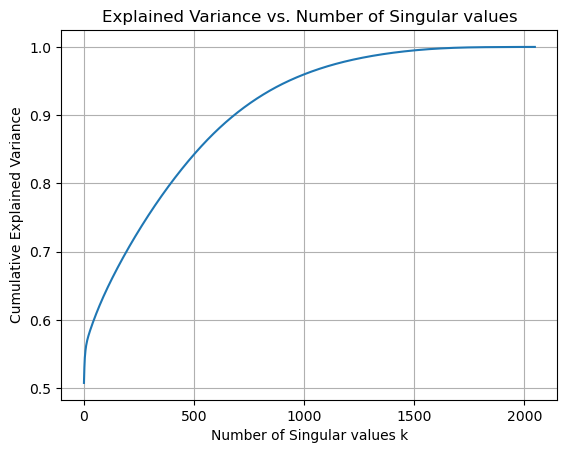

Number of singular values to reach 60.0% explained variance: 47
Number of singular values to reach 75.0% explained variance: 288
Number of singular values to reach 80.0% explained variance: 395
Number of singular values to reach 90.0% explained variance: 683
Number of singular values to reach 95.0% explained variance: 929

The MSE with 929 components is:  0.0077


In [93]:
### Add processing code here
csr_data, keys_to_index, indices_to_key = convert_to_binary_matrix(data_d3)

total_variance = np.sum(csr_data.power(2))

U, S, V = svds(csr_data.astype(float), k=min(csr_data.shape) - 1)

# Since svds returns the singular values in ascending order, sort them in descending order
sorted_indices = np.argsort(S)[::-1]
S_sorted = S[sorted_indices]
U_sorted = U[:, sorted_indices]
V_sorted = V[sorted_indices, :]

cumulative_explained_variance = np.cumsum(S_sorted**2) / total_variance
thresholds = [0.6, 0.75, 0.8, 0.9, 0.95]

k_values = np.arange(1, min(csr_data.shape))
plt.plot(k_values, cumulative_explained_variance)
plt.xlabel("Number of Singular values k")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Singular values")
plt.grid(True)
plt.show()

for threshold in thresholds:
    # get the index od the optimal number of k
    k_optimal = np.argmax(cumulative_explained_variance >= threshold) + 1
    print(f"Number of singular values to reach {threshold*100}% explained variance: {k_optimal}")

final_threshold = 0.95
k_optimal = np.argmax(cumulative_explained_variance >= final_threshold) + 1

U, S, V = svds(csr_data.astype(float), k=k_optimal) # perform SVD with optimal k

reconstructed_matrix = U @ np.diag(S) @ V
original_dense_matrix = csr_data.toarray()

MSE=((original_dense_matrix - reconstructed_matrix)**2).mean()
print("")
print("The MSE with %d components is: %7.4f" % (k_optimal, MSE))

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)

### Summary of code and key findings:

To perform dimensionality reduction there are a many different options. In a Data Mining concept doing Feature Selection is a rather uncommon approach as the there is a large amount of data, containing usually many features. Therefore dimensionality reduction is a more common approach for these large amounts of data. The most two common approaches are PCA and SVD. As our data is very sparse we decide to stick to SVD as it is known as a good option to work with sparse matrices.

In SVD the data, in form of a matrix, get divided into three matrices: U, S, V. The method transforms the original data into a new set of orthogonal basis vectors (singular vectors) that capture the most significant directions of variance in the data. For this reason the method requires the parameter k, which determines the number of singular values the data should be transformed in. Depending on the percentage of explained variance the transformed data should still include, this parameter has to be chosen accordingly.

As calculating every possible configuration of k would be quite computational intensive, this approach is not an option. As k, determines the number of singular vectors in the transformed matrices, we know, that setting this value to the number of columns/ features of the original data will result in a explained variance of 100% and therefore no loss will be achieved. Looking at the matrix S, which is a diagonal matrix with singular values on the diagonal, we can obtain the singular values that the data got transformed to. Using these values and performing the cumulative sum of the values squared and divide this by the total variance of the data, we get the cumulative explained variance of the singular values. By doing so we can investigate the percantage of explained variance that x-number of singular values capture/ explain. This way we can find the optimal value for k to achieve the desired explained variance in the transformed data.

Looking at the implementation, we first convert our data into a binary sparse matrix. To perform SVD we are using **svds()** from scipy.sparse.linalg. This method can handle sparse matrices in the scipy-format. We set k to the number of columns of our data - 1, as the index starts at 0. As the resulting matrices from svds() returns the singular values in ascending order, we need to sort them in descending order. Only this way we can easily cumulate the sum of the singular values. In order to get the cumulative explained variance we apply the following formular: **np.cumsum(S_sorted^2) / total_variance**

Plotting the results gives us interesting insights (total number of columns = 2048 for data_d3):
- Using only 47 singular values we already achieve 60% of explained variance
- Using 288 we achieve 75%
- Using 683 we achieve 90%
- Using 929 we achieve 95% of explained variance. This is less than half of all columns of the original data

Looking at these results it becomes clear why dimensionality reduction is so powerful and useful.

As we don't want to loose too much information we decide on a threshold of 95%, therefore k = 929. Lastly we calculate the SVD with now the optimal number of k for our defined goal. **The resulting U matrix contains the new representation of the reduced data.** As a last step we calculate the MSE of the original data with the reassembled data, using the three created matrices, and get a value of 0.0077. This shows us, that almost no loss happend. But still, the new matrix U only contains 929 columns (instead of 2048 in the original).


### Full Applicability to Uniprot:

In order to perform LSH and SVD with the whole scope of data different aspects need to be taken into account:

First, Uniprot's vast dataset, composed by approximately 248 million proteins, will require distributed computing approaches to manage both the computational load and the storage effectively.

Converting the data into binary format and then storing them in a sparse matrix is definitely necessary, to reduce computational load and used memory storage.

##### For LSH:
* Parameter Optimization: For example involving more sophisticated methods to determine the optimal number of bands and rows per band (Grid search for cross validation, ML models). As we saw when plotting the time taken for the different settings, choosing the correct number of bands and rows is of high importance.
* Integration with intense Biological Validation: Ensuring that the similar pairs identified through LSH are biologically relevant is essential. This could involve integrating LSH outputs with other biological databases or literature (Literature mining and Database integration) to verify functional relationships.

##### For SVD:
Currently our approach for SVD is already very efficient in our opinion, but a few things need to be adapted:
- Converting the data into binary and storing them in a sparse matrix is very important, especially as the dimensions of the data increase
- The approach to identify the optimal k needs to be adapted:
    - Probably calculating the SVD with k = the number of columns in the data is not a good approach. Therefore a more efficient way to calculate the optimal k needs to be found. But as we see from our results (plot) already a small percentage of the columns explain a large amount of the data. For this reason testing different k's in the range of column-length / 4 should already give promising results
- another thought is to investigate the number of dimensions for the whole Uniport data. It could be, that the number of columns will exceed the number of rows. If this is the case, transposing the matrix and applying SVD on the rows instead of the columns could be a good approach.

##### General Considerations for Implementation:
* Distributed Computing: Both LSH and dimensionality reduction should be implemented within a distributed computing framework to manage the data volume effectively. Technologies like Apache Spark or Hadoop would be employed to parallelize these processes across multiple computing nodes.
* Incremental Learning and Processing: Considering the dynamic nature of Uniprot, where new proteins are continually added, incremental approaches to LSH and SVD might be necessary. This would involve updating the models periodically without reprocessing the entire dataset from scratch.